<a href="https://colab.research.google.com/github/thanhnguyen2612/diveintocode-ml/blob/master/ML_sprint7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

In [242]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [243]:
class ScratchKMeans():
    """
    K-means scratch implementation
    Parameters
    ----------
    n_clusters : int
      Number of clusters
    n_init : int
      How many times to change the initial value of the center point for calculation
    max_iter : int
      Maximum number of iterations in one calculation
    tol : float
      Margin of error between the center point and the center of gravity, which is the reference for ending the iteration
    verbose : bool
      True to output the learning process
    """
    def __init__(self, n_clusters=8, n_init=10,
                 max_iter=300, tol=1e-4, verbose=False):
        # Record hyperparameters as attributes
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
    
    def _init_centers(self, X):
        assert self.n_clusters > 0 and self.n_clusters <= X.shape[0],\
                "Invalid number of clusters"
        return X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
    
    def _distance_to_center(self, data_point, center_point):
        return np.linalg.norm(data_point - center_point) ** 2
    
    def _move_centers(self, X):
        labels = self.predict(X)
        centers = np.zeros_like(self.centers) 
        for k in np.unique(labels):
            X_k = X[labels == k, :]
            centers[k, :] = np.mean(X_k, axis=0)
        return centers
    
    def _sse(self, X):
        labels = self.predict(X)
        sse = sum([self._distance_to_center(x, self.centers[k])
                    for x, k in zip(X, labels)])
        return sse

    def _fit(self, X):
        self.centers = self._init_centers(X)
        for i in range(self.max_iter):
            new_centers = self._move_centers(X)
            if (abs(new_centers - self.centers) < self.tol).all():
                break
            self.centers = new_centers
        sse = self._sse(X)
        return sse

    def fit(self, X):
        """
        Calculate clustering by K-means
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        """
        all_sse = []
        all_centers = []
        for i in range(self.n_init):
            sse = self._fit(X)
            all_sse.append(sse)
            all_centers.append(self.centers.copy())
            if self.verbose:
                print("Iteration", i,
                      "SSE", sse,
                      "\nCenters\n", self.centers)

        idx = np.argmin(all_sse)
        self.cluster_centers_ = all_centers[idx]
        self.inertia_ = all_sse[idx]
        self.labels_ = self.predict(X)
        return self

    def predict(self, X):
        """
        Calculate which cluster the input data belongs to
        """
        def cdist(x):
            return [self._distance_to_center(x, c) for c in self.centers]
        labels = [np.argmin(cdist(x)) for x in X]
        return labels

## Load Simple Dataset 3

In [244]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

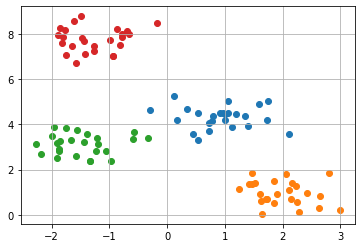

In [245]:
def plot(X, y):
    labels = np.unique(y)
    for label in labels:
        idx = y == label
        plt.scatter(X[idx, 0], X[idx, 1])
    plt.grid(True)
    plt.show()
plot(X, y)

## [Problem 1] Determine the initial value of the center point

In [246]:
def init_centers(X, n_clusters=1):
    """
    @Params:
        X: data samples
        n_clusters: number of clusters/centers
    @Return:
        Initial centers data points
    """
    assert n_clusters > 0 and n_clusters <= X.shape[0],\
           "Invalid number of clusters"
    return X[np.random.choice(X.shape[0], n_clusters, replace=False)]

In [247]:
centers = init_centers(X, 4)
centers

array([[ 1.00952869,  4.45502328],
       [-1.89928142,  2.50466299],
       [-0.65424088,  7.99393132],
       [ 1.89949126,  0.92574633]])

## [Problem 2] Creation of a function to obtain SSE

In [248]:
def distance_to_center(data_point, center_point):
    return np.linalg.norm(data_point - center_point) ** 2

def sum_squared_errors(X, labels, centers):
    """
    @Params:
        X: data point samples
        labels: labels of X corresponding to centers index
        centers: center data points
    @Return:
        Sum of squared errors from data points to centroids (SSE)
    """
    sse = sum([distance_to_center(x, centers[k]) for x, k in zip(X, labels)])
    return sse

In [249]:
sum_squared_errors(X, y, centers)

2518.379489162584

## [Problem 3] Allocation to cluster

In [250]:
def cluster_allocation(X, centers):
    def cdist(x, centers):
        return [distance_to_center(x, c) for c in centers]
    labels = [np.argmin(cdist(x, centers)) for x in X]
    return labels

In [251]:
labels = cluster_allocation(X, centers)
print(labels)
print("SSE:", sum_squared_errors(X, labels, centers))

[0, 2, 0, 0, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 3, 3, 0, 1, 3, 0, 2, 1, 3, 0, 1, 1, 0, 3, 3, 3, 2, 3, 3, 1, 0, 2, 3, 2, 1, 0, 1, 2, 1, 1, 2, 3, 1, 0, 0, 0, 3, 1, 1, 1, 2, 2, 3, 3, 2, 2, 3, 3, 0, 3, 2, 1, 1, 3, 0, 2, 3, 0, 2, 0, 0, 1, 1, 3, 3, 3, 2, 1, 0, 3, 1, 3, 3, 0, 0, 0, 1, 0, 1, 1, 2, 2, 1, 2, 0]
SSE: 73.73191904506507


## [Problem 4] Movement of the center point

In [252]:
def move_centers(X, labels, n_clusters):
    """
    @Params:
        X: data point samples
        y: labels of X via cluster allocation
        n_clusters: number of clusters
    @Return:
        New centroids of clusters
    """
    centers = np.zeros((n_clusters, X.shape[1]))
    for k in np.unique(labels):
        X_k = X[labels == k, :]
        centers[k, :] = np.mean(X_k, axis=0)
    return centers

In [253]:
labels = cluster_allocation(X, centers)
print("Before:", sum_squared_errors(X, labels, centers))

new_centers = move_centers(X, labels, 4)
print(new_centers)
new_labels = cluster_allocation(X, new_centers)
print("After:", sum_squared_errors(X, new_labels, new_centers))

Before: 73.73191904506507
[[ 0.87728     4.28881038]
 [-1.52702451  3.10579592]
 [-1.26811733  7.76378266]
 [ 1.99186903  0.96561071]]
After: 48.784944847351284


## [Problem 5] Repeat

In [254]:
def fit(X, n_clusters, max_iter=300, tol=1e-4):
    """
    @Params:
        X: data samples
        n_clusters: number of clusters
        max_iter: maximum number of iteration
        tol: difference between the center of gravity tolerance
    @Return:
        The result centroids
    """
    centers = init_centers(X, n_clusters)
    for i in range(max_iter):
        labels = cluster_allocation(X, centers)
        new_centers = move_centers(X, labels, n_clusters)
        if (abs(new_centers - centers) < tol).all():
            break
        centers = new_centers
    sse = sum_squared_errors(X, labels, centers)
    return centers, labels, sse

In [255]:
centers, labels, sse = fit(X, 4, 100, 1e-4)
print(centers)
print(sse)

[[-1.26811733  7.76378266]
 [-0.3255195   3.72390954]
 [ 2.10458645  0.61362557]
 [ 1.84900694  1.68295352]]
132.22875558038203


## [Problem 6] Calculate with different initial values

In [256]:
def many_fit(X, n_clusters, n_init=10, max_iter=300, tol=1e-4):
    all_sse = []
    all_centers = []
    for i in range(n_init):
        centers, labels, sse = fit(X, n_clusters, max_iter, tol)
        all_sse.append(sse)
        all_centers.append(centers)
    idx = np.argmin(all_sse)
    centers = all_centers[idx]
    sse = all_sse[idx]
    labels = cluster_allocation(X, centers)
    return centers, labels, sse

In [257]:
centers, labels, sse = many_fit(X, 4)
print(centers)
print(sse)

[[ 0.92578447  4.32475792]
 [ 1.99186903  0.96561071]
 [-1.26811733  7.76378266]
 [-1.47935679  3.11716896]]
48.633783207064035


## [Problem 7] Estimate

In [258]:
def plot_clusters(X, model):
    plt.scatter(X[:, 0], X[:, 1], c=model.predict(X))
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='r')
    plt.grid(True)
    plt.show()

In [259]:
scratch_kmeans = ScratchKMeans(n_clusters=4).fit(X)

[[ 1.99186903  0.96561071]
 [-1.26811733  7.76378266]
 [-1.47935679  3.11716896]
 [ 0.92578447  4.32475792]]
48.633783207064035


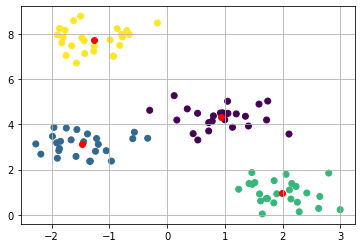

In [260]:
print(scratch_kmeans.cluster_centers_)
print(scratch_kmeans.inertia_)
plot_clusters(X, scratch_kmeans)

In [261]:
from sklearn.cluster import KMeans
sklearn_kmeans = KMeans(n_clusters=4, init='random').fit(X)

[[-1.47935679  3.11716896]
 [ 1.99186903  0.96561071]
 [-1.26811733  7.76378266]
 [ 0.92578447  4.32475792]]
48.63378320706403


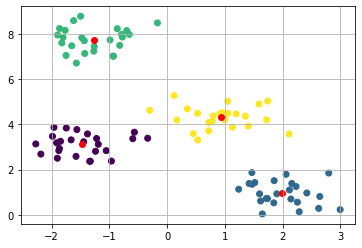

In [262]:
print(sklearn_kmeans.cluster_centers_)
print(sklearn_kmeans.inertia_)
plot_clusters(X, sklearn_kmeans)

## [Problem 8] Implementation of elbow method

In [263]:
def plot_elbow(X, model, max_clusters=10, figsize=(8, 6)):
    all_sse = []
    K_range = range(1, max_clusters + 1)
    for k in K_range:
        model.n_clusters = k
        model.fit(X)
        all_sse.append(model.inertia_)
    plt.figure(figsize=figsize)
    plt.plot(K_range, all_sse, marker='o',
             markersize=6, markeredgewidth=5,
             markeredgecolor='crimson', linewidth=4)
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost of the model (SSE)")
    plt.show()

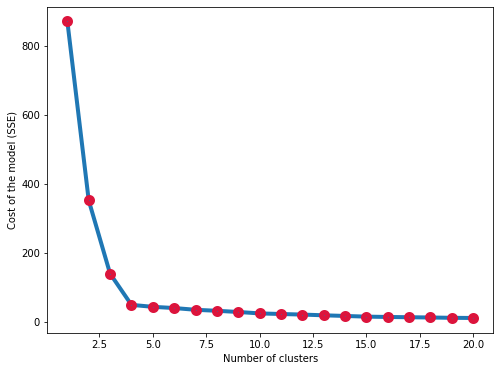

In [264]:
plot_elbow(X, ScratchKMeans(), max_clusters=20)

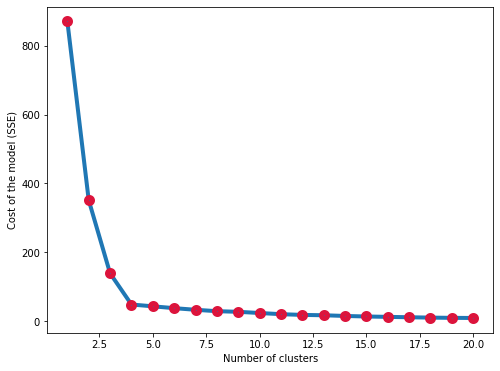

In [265]:
plot_elbow(X, KMeans(), max_clusters=20)

## [Problem 9] (Advance assignment) Silhouette diagram

In [266]:
from matplotlib import cm

def compute_silhouette(X, labels):
    def cohesion(X_k):
        def mean_D(a, X_k):
            return sum(np.linalg.norm(a - b) for b in X_k) / (len(X_k) - 1)
        return np.array([mean_D(x, X_k) for x in X_k])

    def divergence_degree(label_k):
        def mean_D(a, X_k):
            return sum(np.linalg.norm(a - b) for b in X_k) / len(X_k)
        def b(x):
            return [mean_D(x, X[labels == l]) for l in np.unique(labels)
                                                if l != label_k]
        return np.array([min(b(x)) for x in X[labels == label_k]])

    a = np.zeros(X.shape[0])
    b = np.zeros(X.shape[0])
    for label in np.unique(labels):
        a[labels == label] = cohesion(X[labels == label])
        b[labels == label] = divergence_degree(label)
    s = (b - a) / np.maximum(a, b)
    return s, np.mean(s)

def plot_silhouette(silhouette_vals, silhouette_avg, y_km,
                    cluster_labels, n_clusters):
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

In [267]:
from sklearn.metrics import silhouette_score

scratch_score = silhouette_score(X, scratch_kmeans.labels_, random_state=0)
sklearn_score = silhouette_score(X, sklearn_kmeans.labels_, random_state=0)
scratch_s_vals, scratch_s_avg = compute_silhouette(X, scratch_kmeans.labels_)
sklearn_s_vals, sklearn_s_avg = compute_silhouette(X, sklearn_kmeans.labels_)

In [268]:
print(scratch_score)
print(sklearn_score)
print(scratch_s_avg)
print(sklearn_s_avg)

0.7083987104616173
0.7083987104616173
0.7083987104616173
0.7083987104616173


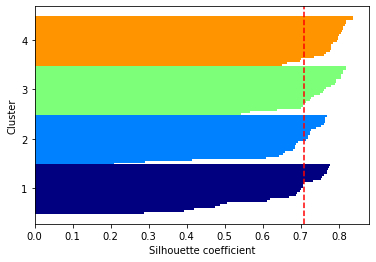

In [269]:
plot_silhouette(scratch_s_vals, scratch_s_avg, scratch_kmeans.labels_,
                np.arange(scratch_kmeans.n_clusters), scratch_kmeans.n_clusters)

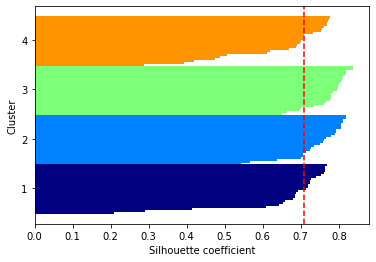

In [270]:
plot_silhouette(sklearn_s_vals, sklearn_s_avg, sklearn_kmeans.labels_,
                np.arange(sklearn_kmeans.n_clusters), sklearn_kmeans.n_clusters)

# Cluster Analysis

In [271]:
import pandas as pd

df = pd.read_csv('wholesale_customers_data.csv')
data = df.drop(columns=["Channel", "Region"])
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


### Dimensionality Reduction by PCA

In [272]:
from sklearn.decomposition import PCA
def plot_pca_explanation_rate(data):
    pca = PCA(n_components=None)
    pca = pca.fit(data)
    var_exp = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(var_exp)
    print(cum_var_exp)
    plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


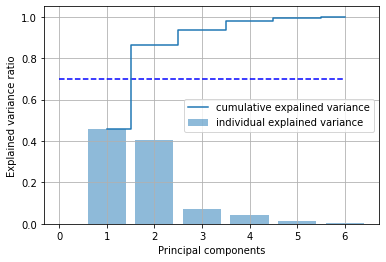

In [273]:
plot_pca_explanation_rate(data)

2-Dimension is good enough

In [274]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca = pca.fit(data)
data_pca = pca.transform(data)

## [Problem 10] Selection of the number of clusters k

I think it is reasonable to cluster into 2 main groups as description:

*   Retail Stores: tend to buy dry stuff
*   Restaurant: tend to bye more fresh ingredients

Further division into sub-groups is possible because of specialized type of grocery stores or restaurants, as well as base on different scale of stores/restaurants

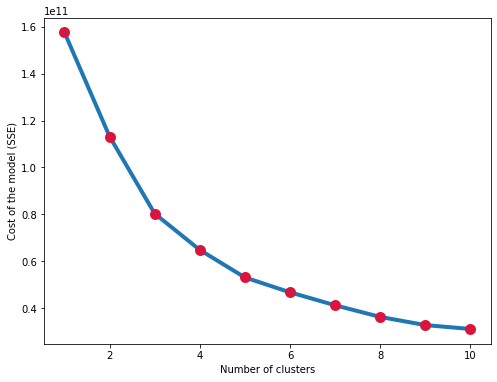

In [275]:
plot_elbow(data.values, ScratchKMeans(), 10)

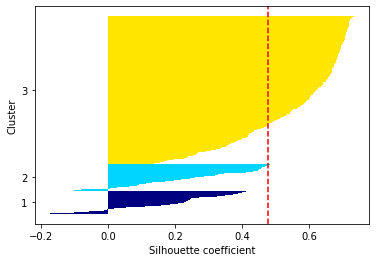

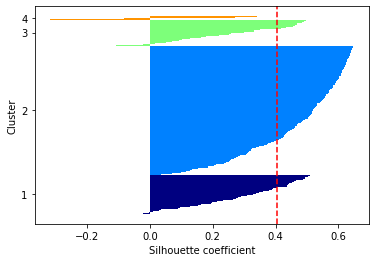

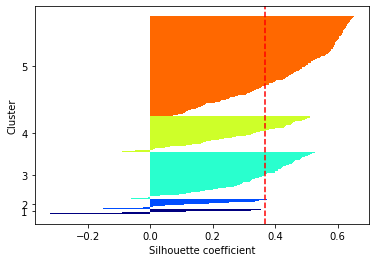

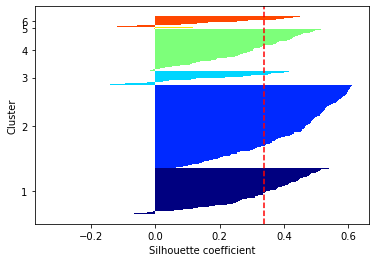

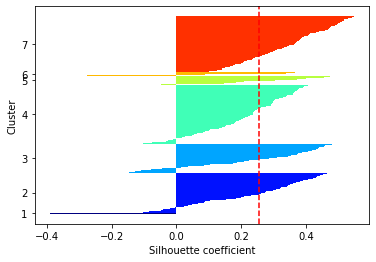

In [276]:
for k in range(3, 8):
    kmeans = ScratchKMeans(n_clusters=k).fit(data.values)
    vals, avg = compute_silhouette(data.values, kmeans.labels_)
    plot_silhouette(vals, avg, kmeans.labels_, np.arange(k), k)

Use elbow method and silhouette metric, choose number of clusters **K = 3**

## [Problem 11] Comparison with known groups

In [277]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


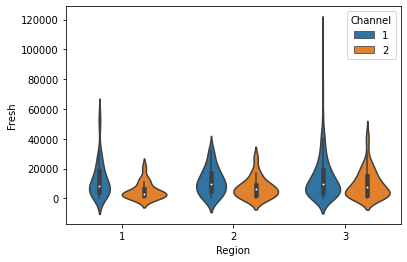

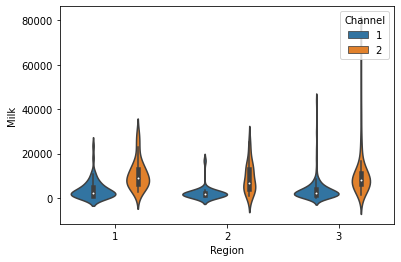

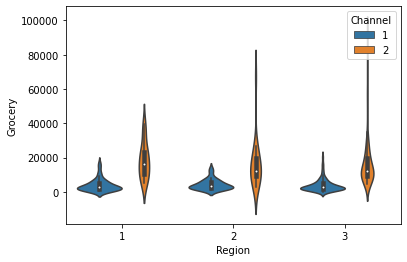

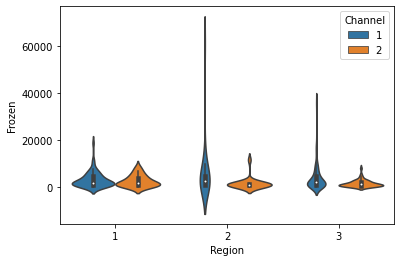

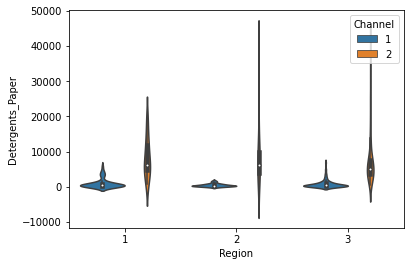

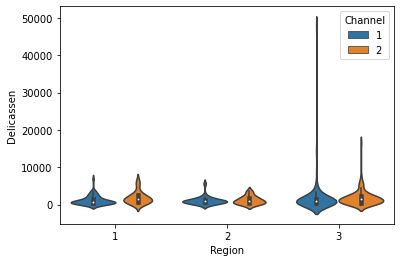

In [278]:
cols = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]
for col in cols:
    sns.violinplot(x="Region", y=col, hue="Channel", data=df)
    plt.show()

It seems that data distribution are pretty the same among known groups except for some outliers (not very clear to infer).

## [Problem 12] Useful information for wholesalers

In [279]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(data.values)
df["label"] = kmeans.labels_

In [280]:
df.drop(columns=["Channel", "Region"]).groupby(by=["label"]).describe()

Fresh                              ... Delicassen                  
       count          mean           std  ...        50%      75%      max
label                                     ...                             
0      329.0   8249.996960   6203.295447  ...      772.0  1542.00  14472.0
1       51.0   8027.411765   9035.038851  ...     1423.0  2716.50  16523.0
2       60.0  35941.400000  15234.899532  ...     1535.5  2880.25  47943.0

[3 rows x 48 columns]

In [281]:
df.groupby(by=['Region', 'Channel']).describe()

Fresh                                     ... label               
                count          mean           std    min  ...   25%  50%  75%  max
Region Channel                                            ...                     
1      1         59.0  12902.254237  12342.008901  514.0  ...   0.0  0.0  0.0  2.0
       2         18.0   5200.000000   5415.521495   18.0  ...   0.0  0.5  1.0  1.0
2      1         28.0  11650.535714   8969.362752    3.0  ...   0.0  0.0  0.0  2.0
       2         19.0   7289.789474   6867.934548  161.0  ...   0.0  0.0  1.0  2.0
3      1        211.0  13878.052133  14746.572913    3.0  ...   0.0  0.0  0.0  2.0
       2        105.0   9831.504762   9635.394129   23.0  ...   0.0  0.0  1.0  2.0

[6 rows x 56 columns]

I prefer looking at figures to tables..

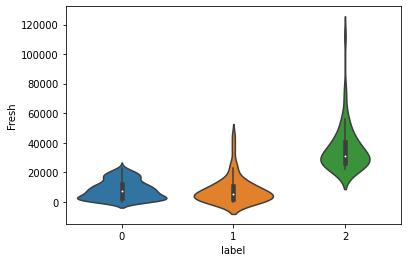

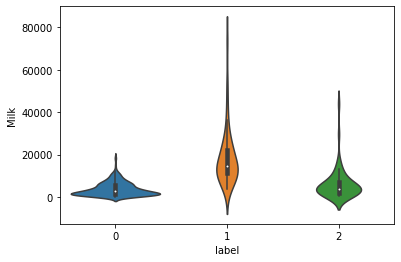

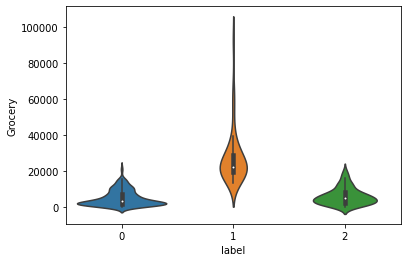

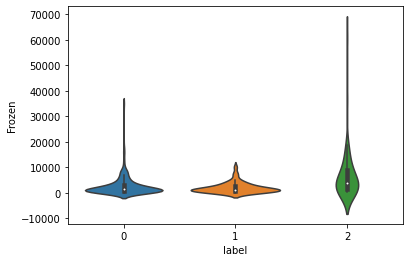

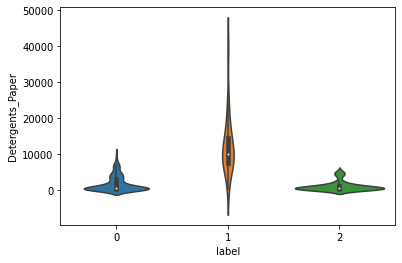

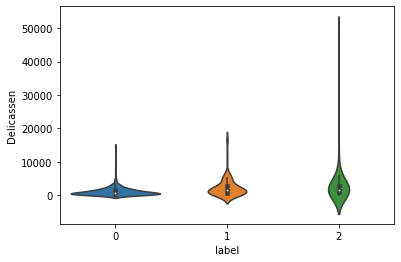

In [282]:
cols = ["Fresh", "Milk", "Grocery", "Frozen",
        "Detergents_Paper", "Delicassen"]
for col in cols:
    sns.violinplot(x="label", y=col, data=df)
    plt.show()


*   Cluster 0: spends relatively less money on wholesale product (maybe the cluster of small retailers/grocery stores).
*   Cluster 1: interested in 'Milk', 'Grocery' and 'Detergents_Paper'.
*   Cluster 2: spends more money on 'Fresh', 'Frozen' and 'Delicassen' than other clusters.

Base on 'Channel' and 'Region':
*   Group of region 3 which favors 'Delicassen' also favors 'Milk' and 'Fresh' (not 'Frozen')
*   Whilst region 2 shows difference in 'Frozen' product wholesale.
*   Group of region 1 spends less and stable (average amount of money spent is low and small variance), which is fairly similar to cluster 0.

## [Problem 13] (Advance assignment) Investigation of other methods

### **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise)
| Advantages | Disadvantages |
| --- | --- |
| Can discover arbitrarily shaped clusters | Not good if dataset is too sparse or variant density |
| Doesn't require to specify number of clusters beforehand | Determine hyperparameters is non-trivial in some case |
| Robust towards outliers (noise data) | Hard to scale for parallel system (slow if large dataset) |

### **t-SNE** (t-Distributed Stochastic Neighbor Embedding)
| Advantages | Disadvantages |
| --- | --- |
| Able to interpret complex polynomial relationship, non-linear data | Computational expensive |
| Preserves local and global structure | Non-deterministic even with same hyperparameters |
| | Determine hyperparameters is vital and possible for unwanted results |

### **LLE** (Locally Linear Embedding)
| Advantages | Disadvantages |
| --- | --- |
| Efficiently handle non-linear data | Fails on dataset with noise |
| Preserves local geometric structure on lower dimensional space | Less accurate in preserving global geometry |
| Only 1 hyperparameter needs tuning | Difficulty on non-convex manifolds |
| Computational efficiency | |

## [Problem 14] (Advance assignment) Use of t-SNE and DBSCAN

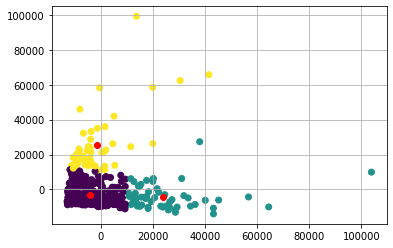

In [284]:
plot_clusters(data_pca, ScratchKMeans(n_clusters=3).fit(data_pca))

In [298]:
from sklearn.manifold import TSNE

data_tsne = TSNE(n_components=2).fit_transform(data.values)

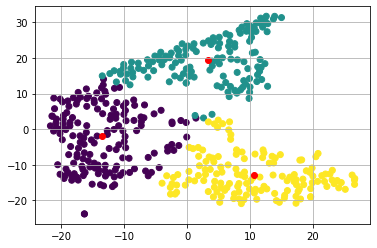

In [299]:
plot_clusters(data_tsne, ScratchKMeans(n_clusters=3).fit(data_tsne))

Dimensionality reduction with t-SNE shows a clearer plot of data clusters by K-means.

In [360]:
from sklearn.cluster import DBSCAN

labels = DBSCAN(eps=5000, min_samples=3).fit_predict(data_pca)

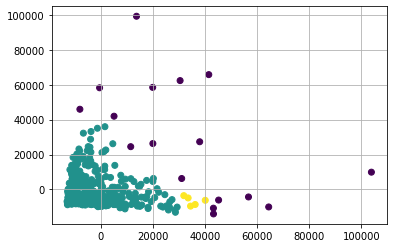

In [361]:
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels)
plt.grid(True)
plt.show()

Use DBSCAN can detect outliers from dense dataset very well, but PCA doesn't scale data values so **$\epsilon$ of DBSCAN** is hard to tune.

In [409]:
from sklearn.cluster import DBSCAN

labels = DBSCAN(eps=2.9, min_samples=3).fit_predict(data_tsne)

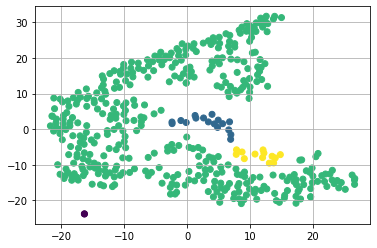

In [410]:
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels)
plt.grid(True)
plt.show()